In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import os
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Step 1: Load the dataset

file_path = "/content/drive/MyDrive/Data Science Projects/App/app/static/market.csv"
data = pd.read_csv(file_path, sep=';')
output_path = os.path.join("/content/drive/MyDrive/Data Science Projects/App/app/static")
os.makedirs(output_path, exist_ok=True)


In [3]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())

Data Head:
    BillNo                             Itemname  Quantity              Date  \
0  536365   WHITE HANGING HEART T-LIGHT HOLDER         6  01.12.2010 08:26   
1  536365                  WHITE METAL LANTERN         6  01.12.2010 08:26   
2  536365       CREAM CUPID HEARTS COAT HANGER         8  01.12.2010 08:26   
3  536365  KNITTED UNION FLAG HOT WATER BOTTLE         6  01.12.2010 08:26   
4  536365       RED WOOLLY HOTTIE WHITE HEART.         6  01.12.2010 08:26   

  Price  CustomerID         Country  
0  2,55     17850.0  United Kingdom  
1  3,39     17850.0  United Kingdom  
2  2,75     17850.0  United Kingdom  
3  3,39     17850.0  United Kingdom  
4  3,39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity

In [4]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")



Column Details:
Column: BillNo, Type: object, Unique values: 21665
Column: Itemname, Type: object, Unique values: 4185
Column: Quantity, Type: int64, Unique values: 690
Column: Date, Type: object, Unique values: 19641
Column: Price, Type: object, Unique values: 1285
Column: CustomerID, Type: float64, Unique values: 4297
Column: Country, Type: object, Unique values: 30


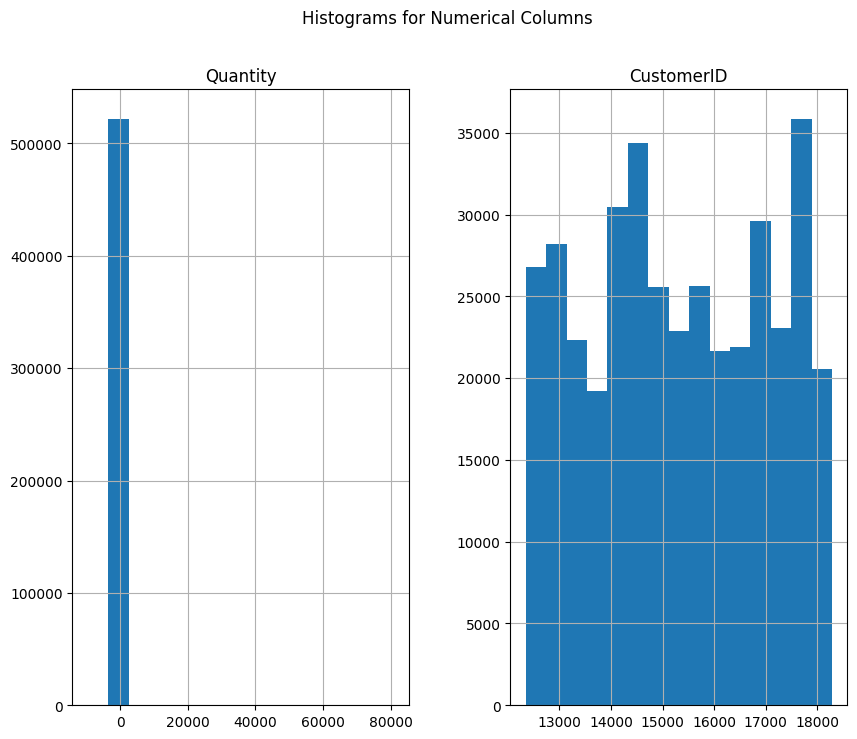

In [5]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "market_histograms.png"))


In [6]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

Number of missing values in each column before filling:
BillNo             0
Itemname        1455
Quantity           0
Date               0
Price              0
CustomerID    134041
Country            0
dtype: int64


In [9]:
# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)


In [10]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")



Values used to fill columns with missing values:
BillNo: 573585
Itemname: WHITE HANGING HEART T-LIGHT HOLDER
Quantity: 10.090435272303779
Date: 31.10.2011 14:41
Price: 1,25
CustomerID: 15316.931710233672
Country: United Kingdom


In [16]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list



Outliers Detected for Quantity:
        BillNo                            Itemname  Quantity  \
9       536367       ASSORTED COLOUR BIRD ORNAMENT        32   
26      536370           ALARM CLOCK BAKELIKE PINK        24   
27      536370            ALARM CLOCK BAKELIKE RED        24   
30      536370                     STARS GIFT TAPE        24   
31      536370          INFLATABLE POLITICAL GLOBE        48   
...        ...                                 ...       ...   
522031  581585  MULTI COLOUR SILVER T-LIGHT HOLDER        24   
522037  581585     SET 12 RETRO WHITE CHALK STICKS        24   
522038  581585         BOX OF 24 COCKTAIL PARASOLS        25   
522046  581586    SET OF 3 HANGING OWLS OLLIE BEAK        24   
522047  581586       RED RETROSPOT ROUND CAKE TINS        24   

                    Date Price  CustomerID         Country  
9       01.12.2010 08:34  1,69     13047.0  United Kingdom  
26      01.12.2010 08:45  3,75     12583.0          France  
27      01.12.2

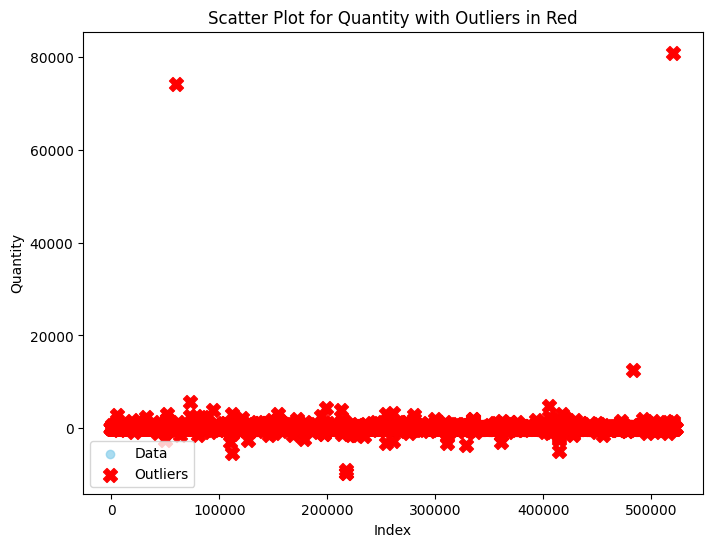

In [17]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"market_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

In [ ]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Country', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Country Class Labels (Including Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "market_outliers_Country.png"))


In [21]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers


In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Country', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Country Class Labels (After Removing Outliers)", y=1.02)
# plt.show()
plt.savefig(os.path.join(output_path, "market_removed_outliers_Country.png"))


In [19]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['Country'] = label_encoder.fit_transform(data['Country'])

In [24]:
# Step 9: Handle non-numeric columns in X

# Check for mixed types in each object column
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Country':  # Avoid encoding the target variable
        # Convert mixed types to strings
        data[column] = data[column].astype(str)

        # Apply LabelEncoder
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

In [25]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['Country'])  # Features
y = data['Country']  # Target variable

In [26]:
# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [28]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

In [29]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)


In [30]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


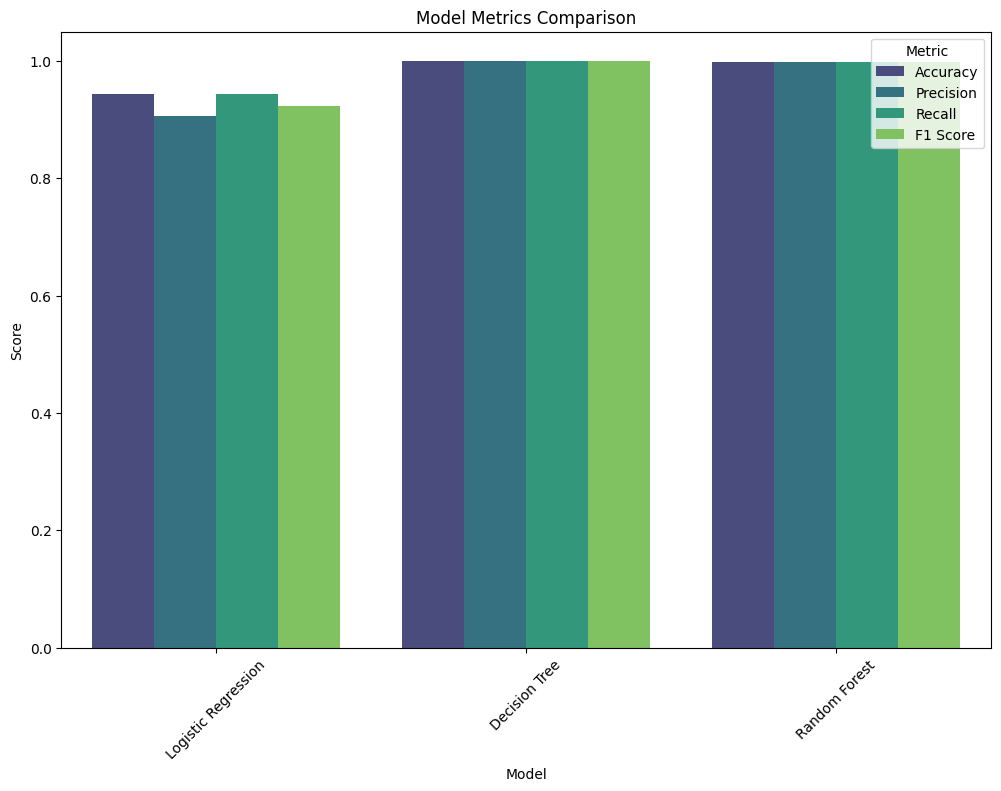

In [31]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
plt.savefig(os.path.join(output_path, "market_metrics.png"))

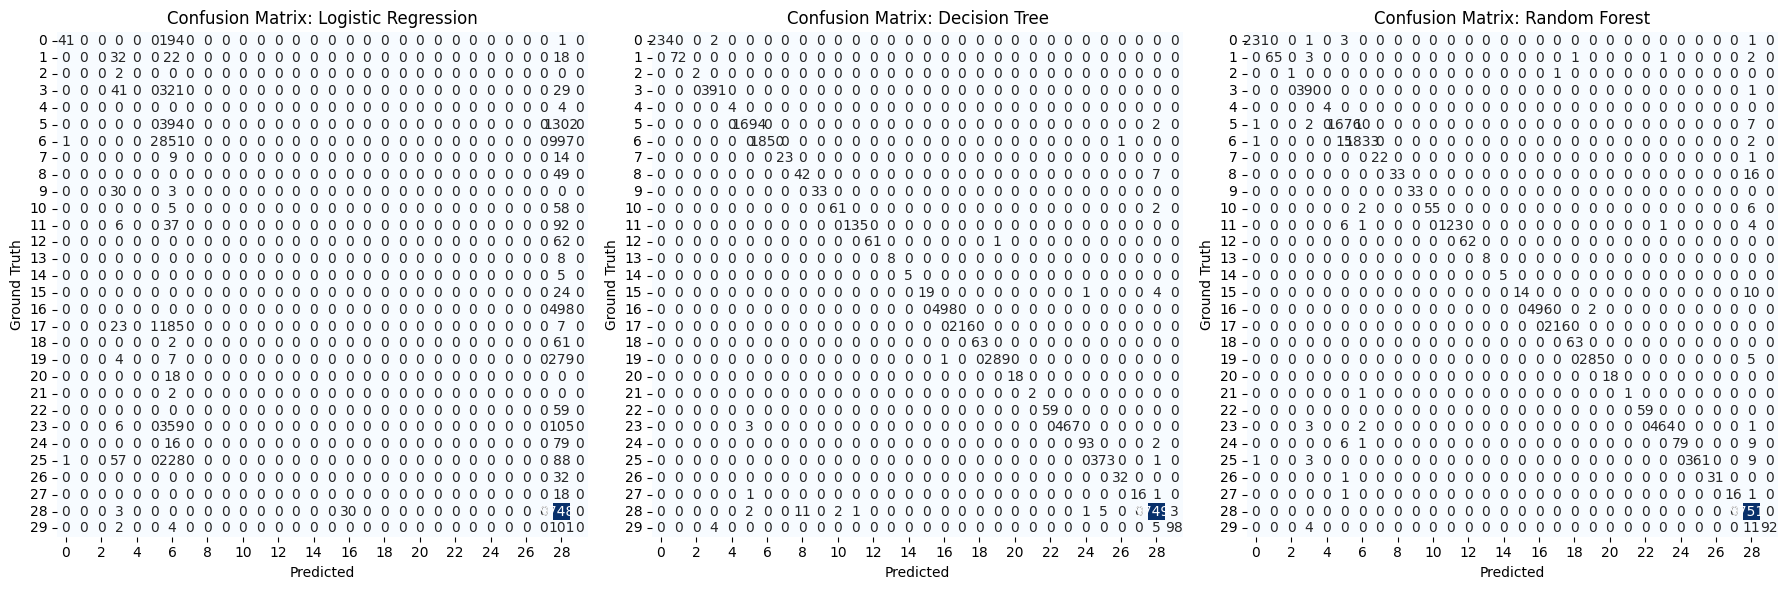

In [32]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "market_metrix.png"))


In [33]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.17      0.29       236
           1       0.00      0.00      0.00        72
           2       0.00      0.00      0.00         2
           3       0.20      0.10      0.14       391
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00      1696
           6       0.32      0.46      0.38      1851
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        63
          11       0.00      0.00      0.00       135
          12       0.00      0.00      0.00        62
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        24
          16       0.00      0.00